In [1]:
"""
Plot the tuning parameters of individual units in each network, over time during training.
Figure 9
"""

import matplotlib.pyplot as plt
import os, sys
import numpy as np
from matplotlib import cm
from copy import deepcopy

##%% paths
root = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(os.path.join(root, 'code', 'analysis_code'))
import load_activations
import plot_utils

colors_main, colors_sf = plot_utils.get_cmaps_biasCNN()

figfolder = os.path.join(root,'figures','UnitTuning')

In [2]:
#%% Parameters
# plotting network trained on upright images, at several time steps.
training_strs = ['scratch_imagenet_rot_0_cos','scratch_imagenet_rot_0_cos','scratch_imagenet_rot_0_cos','scratch_imagenet_rot_0_cos']  # model trained on upright images

ckpt_strs=['50000','100000','200000','400000']
#%% define other basic parameters
nImageSets = 4
model='vgg16'
param_str='params1'
dataset_str=['FiltIms14AllSFCos']
color_ind=3
init_nums=[0]    
nInits = np.size(init_nums)
param_strs=[]
for ii in range(len(init_nums)):    
  if init_nums[ii]>0:
    param_strs.append(param_str+'_init%d'%init_nums[ii])
  else:
    param_strs.append(param_str)

nTrainingSchemes = len(training_strs)

# when identifying well-fit units, what criteria to use?
r2_cutoff = 0.4;

# this set doesn't have different spat frequency levels, just broadband
sf_labels=['broadband SF']
nSF=1
sf=0

In [3]:
#%% loop to load all the data (orientation tuning fit parameters for all units)

#%% loop to load all the data (orientation tuning fit parameters for all units)
for tr in range(len(training_strs)):
  
  training_str = training_strs[tr]
  ckpt_num = ckpt_strs[tr]
  dataset = dataset_str[0]  
 
  ii=0  
  # path info  
  param_str = param_strs[ii]
  save_path = os.path.join(root,'saved_analyses','unit_tuning',model,training_str,param_str,dataset) 
 
  # get information about the images/network
  if tr==0:
     info = load_activations.get_info(model,dataset)
     nSF = np.size(np.unique(info['sflist']))
     nLayers = info['nLayers']      
     layer_labels = info['layer_labels']    
     nOri = info['nOri']
     ori_axis = np.arange(0, nOri,1)
         
     # initialize these arrays (will be across all init of the network)    
     fit_pars_all = [] 
     r2_all = []     
     
  # find the random seed(s) for the jitter that was used
  files=os.listdir(os.path.join(save_path))
  [jitt_file] = [ff for ff in files if '%s_fit_jitter'%layer_labels[0] in ff and 'pars' in ff and ckpt_strs[tr] in ff];  
  rand_seed_str = jitt_file[jitt_file.find('jitter')+7:jitt_file.find('jitter')+13]  

  fit_pars = [] 
  r2 = []   
  # loop over layers and load fit parameters
  for ll in range(nLayers):

    # load fit r2 [nUnits x nSF x nImageSets] 
    file_name= os.path.join(save_path,'%s_fit_jitter_%s_r2_each_sample_eval_at_ckpt_%s.npy'%(layer_labels[ll],rand_seed_str,ckpt_num))
    print('loading from %s\n'%file_name)
    r2.append(np.load(file_name))
    
    # load the fit parameters [nUnits x nSF x nPars]
    # in par dimension, [0,1,2,3,4] are [center, k, amplitude, baseline, FWHM size]
    file_name= os.path.join(save_path,'%s_fit_jitter_%s_pars_eval_at_ckpt_%s.npy'%(layer_labels[ll],rand_seed_str,ckpt_num))
    print('loading from %s\n'%file_name)
    fit_pars.append(np.load(file_name))
 

  r2_all.append(r2)
  fit_pars_all.append(fit_pars)


loading from /mnt/neurocube/local/serenceslab/maggie/biasCNN/saved_analyses/unit_tuning/vgg16/scratch_imagenet_rot_0_cos/params1/FiltIms14AllSFCos/conv1_1_fit_jitter_727724_r2_each_sample_eval_at_ckpt_50000.npy

loading from /mnt/neurocube/local/serenceslab/maggie/biasCNN/saved_analyses/unit_tuning/vgg16/scratch_imagenet_rot_0_cos/params1/FiltIms14AllSFCos/conv1_1_fit_jitter_727724_pars_eval_at_ckpt_50000.npy

loading from /mnt/neurocube/local/serenceslab/maggie/biasCNN/saved_analyses/unit_tuning/vgg16/scratch_imagenet_rot_0_cos/params1/FiltIms14AllSFCos/conv1_2_fit_jitter_727724_r2_each_sample_eval_at_ckpt_50000.npy

loading from /mnt/neurocube/local/serenceslab/maggie/biasCNN/saved_analyses/unit_tuning/vgg16/scratch_imagenet_rot_0_cos/params1/FiltIms14AllSFCos/conv1_2_fit_jitter_727724_pars_eval_at_ckpt_50000.npy

loading from /mnt/neurocube/local/serenceslab/maggie/biasCNN/saved_analyses/unit_tuning/vgg16/scratch_imagenet_rot_0_cos/params1/FiltIms14AllSFCos/pool1_fit_jitter_727724_r

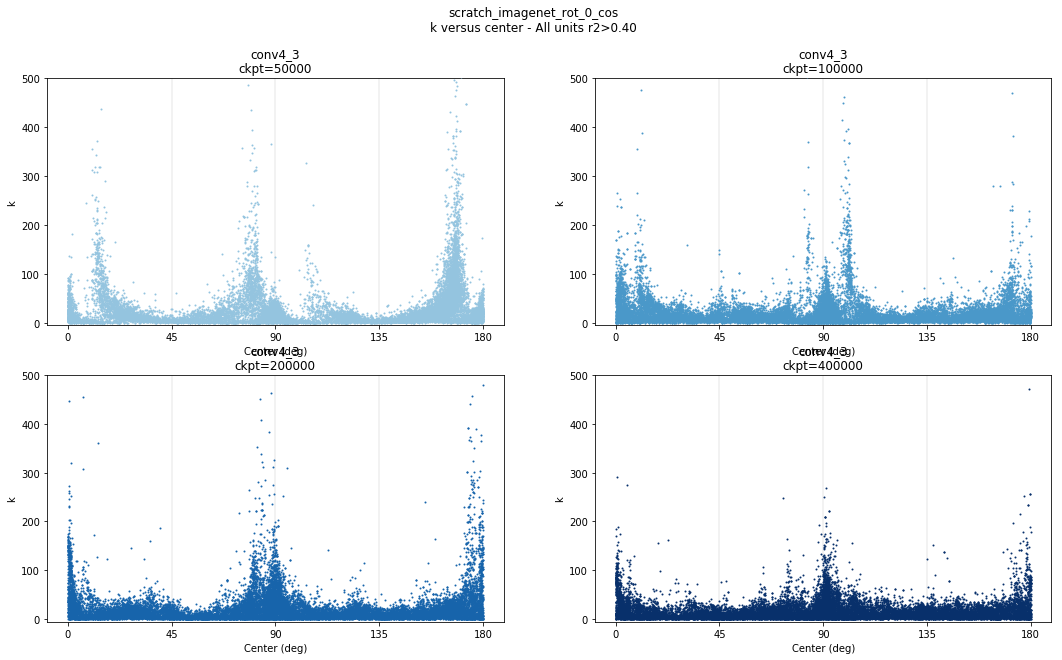

In [9]:
#%% Plot K versus the center (scatter plot), for an example layer at 4 timepts.
# Figure 9B.

layers2plot = [12]
ll=0

pp2plot=1 # index of k in the parameters array
ppname='k'
maxpts=20000
ylims = [-5,500]
alpha=1
npx = 2
npy = 2

plt.rcParams.update({'font.size': 10})
plt.close('all')
plt.rcParams['pdf.fonttype']=42
plt.rcParams['ps.fonttype']=42    
plt.rcParams['figure.figsize']=[18,10]


tr2plot=[0,1,2,3] 
cols_grad = np.moveaxis(np.expand_dims(cm.Blues(np.linspace(0,1,len(tr2plot)+2)),axis=2),[0,1,2],[0,2,1])
cols_grad = cols_grad[np.arange(2,2+len(tr2plot),1),:,:]

plt.figure()
for tr in range(len(tr2plot)):

  plt.subplot(npx,npy, tr+1)
 
  allc = []  
  allk = []
  ii=0
  
  rvals = deepcopy(np.squeeze(np.mean(r2_all[tr2plot[tr]][layers2plot[ll]][:,sf,:],axis=1)))
  rvals[np.isnan(rvals)] = -1000
  inds2use = np.where(rvals>r2_cutoff)[0]
  # get values of center and other parameter of interest (k)
  cvals = deepcopy(np.squeeze(fit_pars_all[tr2plot[tr]][layers2plot[ll]][inds2use,sf,0]))
  parvals = deepcopy(np.squeeze(fit_pars_all[tr2plot[tr]][layers2plot[ll]][inds2use,sf,pp2plot]))    
 
  allc = np.concatenate((allc,cvals),axis=0)
  allk = np.concatenate((allk,parvals),axis=0)
    
  cvals=allc
  parvals=allk
    
  if np.size(cvals)>maxpts:
    inds2plot = np.random.randint(0,np.size(cvals),maxpts)
  else:
    inds2plot = np.arange(0,np.size(cvals))
  plt.plot(cvals[inds2plot],parvals[inds2plot],'o',markersize=1,color=cols_grad[tr2plot[tr],0,:],alpha=alpha,zorder=100)

  plt.title('%s\nckpt=%s'%(layer_labels[layers2plot[ll]], ckpt_strs[tr2plot[tr]]))
  plt.ylim(ylims)
  plt.xlabel('Center (deg)')
  plt.ylabel(ppname)
  plt.xticks(np.arange(0,181,45))
  
  for xx in np.arange(45,180,45):
    plt.axvline(xx,color=[0.95, 0.95, 0.95],linewidth=2)
      
  plt.suptitle('%s\n%s versus center - All units r2>%.2f\n'%(training_str,ppname,r2_cutoff));

  figname = os.path.join(figfolder, 'KvsCenter_ckpt%s.pdf'%ckpt_strs[tr2plot[tr]])
  plt.savefig(figname, format='pdf',transparent=True)


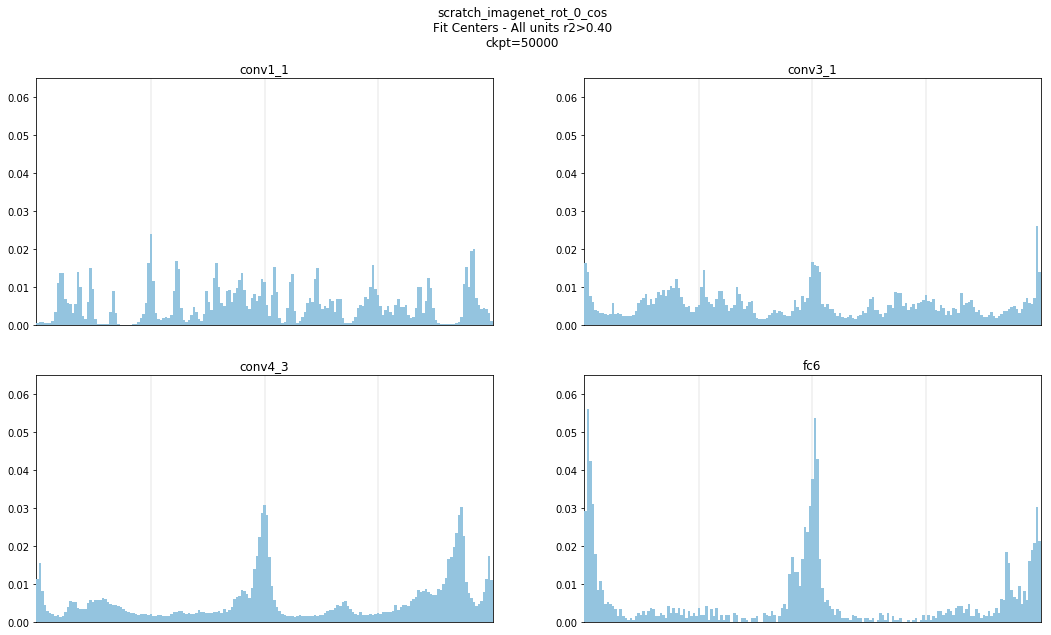

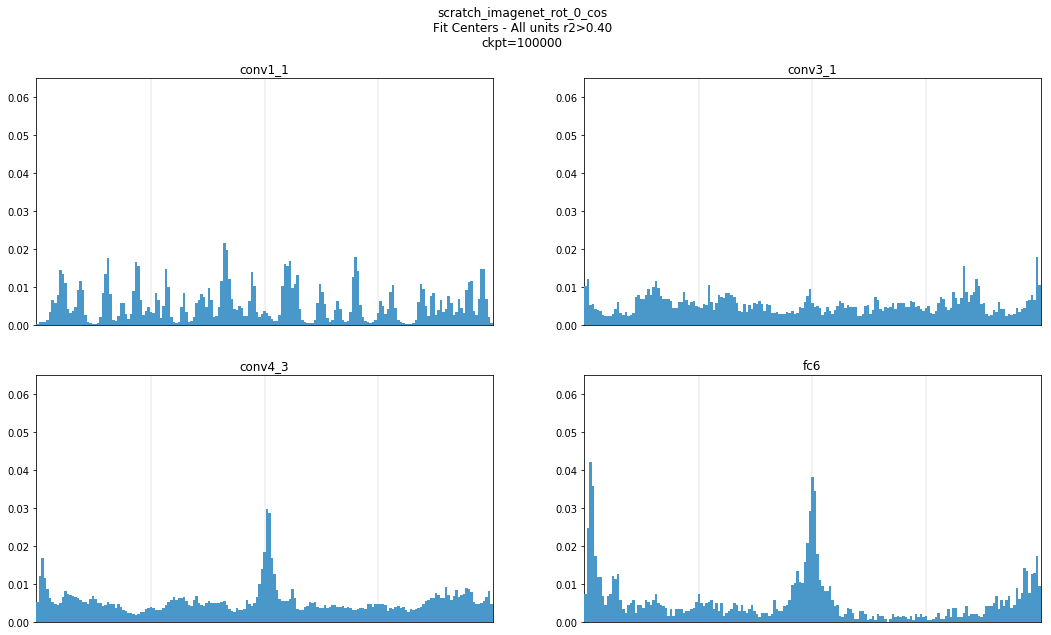

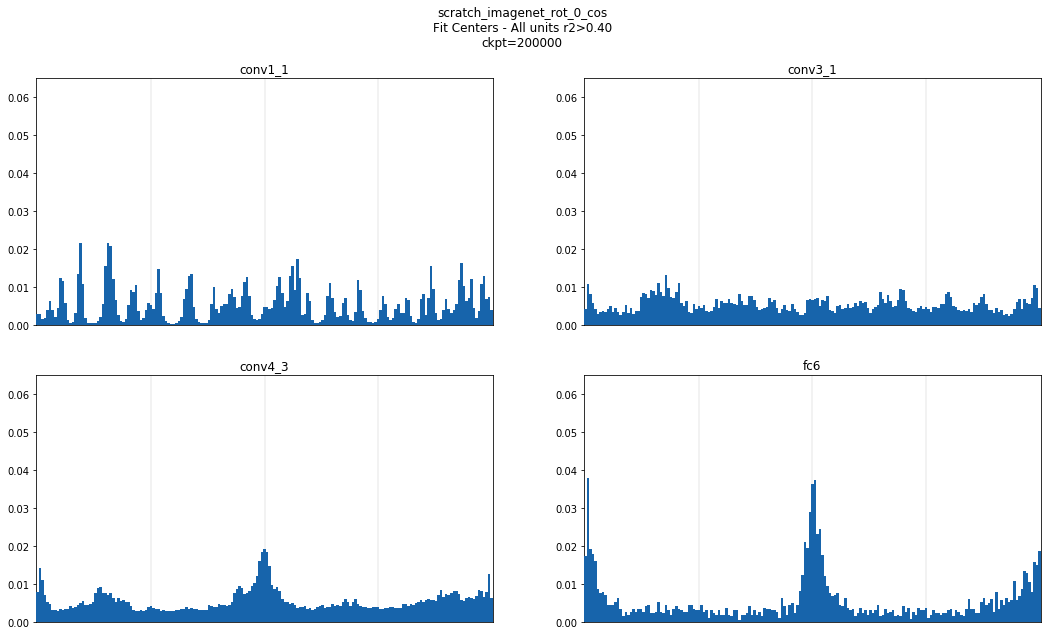

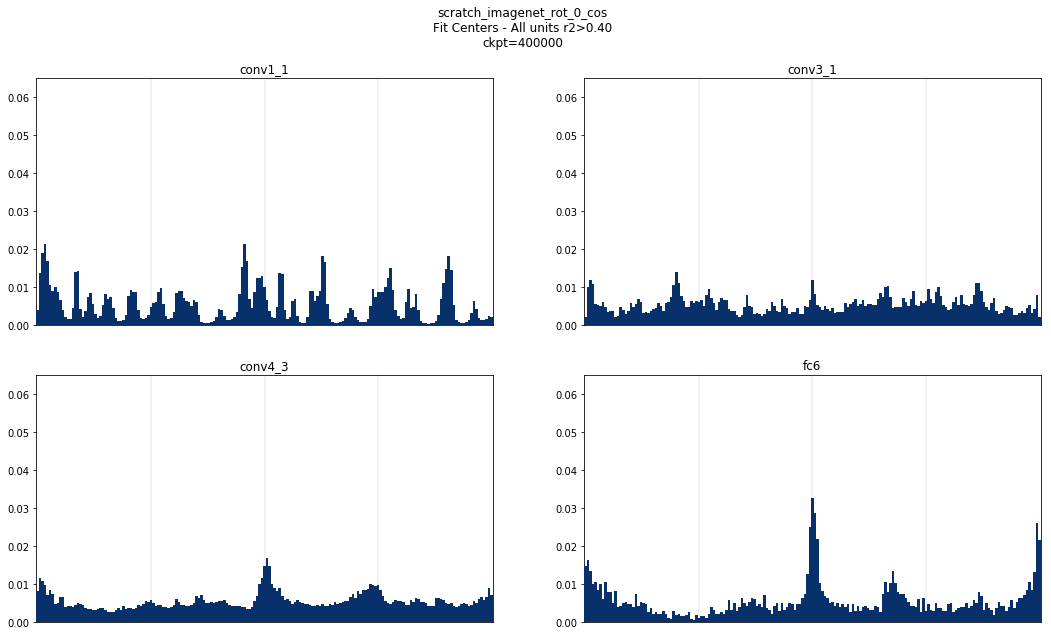

In [10]:
# %% Plot histogram of tuning centers, for four example layers. 

plt.rcParams.update({'font.size': 10})
plt.close('all')
plt.rcParams['pdf.fonttype']=42
plt.rcParams['ps.fonttype']=42    
plt.rcParams['figure.figsize']=[18,10]

# bins for the histograms
ori_bin_size=1
ori_bins = np.arange(-ori_bin_size/2,nOri+ori_bin_size,ori_bin_size)
bin_centers = ori_bins[0:np.size(ori_bins)-1]+ori_bin_size/2

layers2plot=np.asarray([0,6,12,18])
npx = np.ceil(np.sqrt(np.size(layers2plot)))
npy = np.ceil(np.size(layers2plot)/npx)
 
sf=0
ylims = [0, 0.065]
tr2plot=[0,1,2,3] 

cols_grad = np.moveaxis(np.expand_dims(cm.Blues(np.linspace(0,1,len(tr2plot)+2)),axis=2),[0,1,2],[0,2,1])
cols_grad = cols_grad[np.arange(2,2+len(tr2plot),1),:,:]

for tr in range(len(tr2plot)):
  
  plt.figure()
  
  for ll in range(np.size(layers2plot)):
    plt.subplot(npx,npy, ll+1)
     
   
    vals_all = []
    
    ii=0
    vals = deepcopy(np.squeeze(fit_pars_all[tr2plot[tr]][layers2plot[ll]][:,sf,0]))
    rvals = deepcopy(np.squeeze(np.mean(r2_all[tr2plot[tr]][layers2plot[ll]][:,sf,:],axis=1)))   
    rvals[np.isnan(rvals)] = -1000    
    vals=vals[np.where(rvals>r2_cutoff)[0]]
    
    vals_all = np.concatenate((vals_all,vals),axis=0)
  
    vals_all = np.ravel(vals_all)
    h = np.histogram(vals_all, ori_bins) 
    # divide by total to get a proportion.
    real_y = h[0]/np.sum(h[0])
    
    plt.bar(bin_centers, real_y,width=ori_bin_size,color=cols_grad[tr2plot[tr],0,:],zorder=100)
    
    for xx in np.arange(45,180,45):
      plt.axvline(xx,color=[0.95, 0.95, 0.95],linewidth=2)
    plt.xlim([np.min(ori_bins), np.max(ori_bins)])
    plt.title('%s'%(layer_labels[layers2plot[ll]])) 
    plt.ylim(ylims)
    if ll==nLayers-1:
        plt.xlabel('Orientation (deg)')
        plt.ylabel('Prop. Units')
        plt.xticks(np.arange(0,nOri+1,45))
    else:
        plt.xticks([]) 
        
  plt.suptitle('%s\nFit Centers - All units r2>%.2f\nckpt=%s'%(training_str,r2_cutoff,ckpt_strs[tr2plot[tr]]));
  
  figname = os.path.join(figfolder, 'Centerhist_ckpt%s.pdf'%ckpt_strs[tr2plot[tr]])
  plt.savefig(figname, format='pdf',transparent=True)
